In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

% matplotlib inline

In [2]:
length = 8

signal = 'dIm EP Peptide'
# signal = 'dIm EP Streptavidin'

# convert dIm (rad) to Gamma (g/cm^2), ignore negative sign of dIm
dIm_to_gamma = 9.36757 * 10**-5

aggregated_file = '18 EP dIm and dR Signals aggregated.csv'

# Base peptide sequences

In [3]:
if   length == 8:
    base = 'WTHPQFAT'
elif length == 9:
    base = 'LQWHPQAGK'
elif length == 12:
    base = 'GKFPIPLGKQSG'
elif length == 13:
    base = 'NGQFQVWIPGAQK'
else:
    print 'No base of such length'
    
aminoacids = ['A', 'C', 'D', 'E', 'F',
              'G', 'H', 'I', 'K', 'L',
              'M', 'N', 'P', 'Q', 'R',
              'S', 'T', 'V', 'W', 'Y']

# Creating list of peptide names

In [4]:
def namelist(base, n):
    names = []
    for a in aminoacids:
        names.append(base[:n - 1] + a + base[n:])
    return names

# Subsetting data

In [5]:
def reorder(data, names):
    # moves base peptide row to the first position
    base_index = data[data['Peptide'] == base].index[0]
    reindex = [-1 if x == base_index else x for x in data.index]
    data.index = reindex
    data = data.sort_index()
    return data

In [6]:
def subset(base, n):
    names = namelist(base, n)
    data = pd.read_csv(aggregated_file, header = 0)
    data = data[data['Peptide Length'] == len(base)]
    data = data[data['Peptide'].isin(names)]
    assert len(data) == 20
#    data = reorder(data, names)
    return data

In [7]:
def plot_series(data, n, signal, filename):
    
    # creating numerical arrays for data and errorbars

    x         = np.array(data[signal + ' Mean NN'])
    xbar_hi   = np.array(data[signal + ' SE'])
    
    # rescale
    x       = [e * dIm_to_gamma * 10**7 for e in x]
    xbar_hi = [e * dIm_to_gamma * 10**7 for e in xbar_hi]
    xbar_lo = xbar_hi[:]
    
    for i in range(len(x)):
        if x[i] - xbar_lo[i] < 0:
            xbar_lo[i] = x[i]
    
    ylabels = data['Peptide'].tolist()
    y       = range(len(ylabels), 0, -1)

    # start plotting
    
    width = 6
    height = 0.36 * (len(y) + 1.4) + 1.1

    fig = plt.figure(figsize = (width, height))
    
    if signal == 'dIm EP Peptide':
        plt.xlim(left = 0, right = 5.0)
    elif signal == 'dIm EP Streptavidin':
        plt.xlim(left = 0, right = 2.5)
        
    plt.ylim(bottom = min(y) - 0.7, top = max(y) + 0.7)
    
    plt.yticks(y, ylabels)
    plt.grid(alpha = 0.5)

    plt.subplots_adjust(left = 1.8 / width,
                        right = 1 - 0.3 / width,
                        bottom = 0.8 / height,
                        top = 1 - 0.3 / height)

    plt.xlabel(r'Surface mass density $\mathregular{ ( \times 10^{-7} \, g/cm^2 ) }$',
               labelpad = 12, fontsize = 14)     

    # highlighting HPQ and varying aminoacid

    hpq_y = 0.47
    hpq_h = 20
    
    if signal == 'dIm EP Peptide':
        hl_step = 0.15
        hl_x0 = -0.28
    elif signal == 'dIm EP Streptavidin':
        hl_step = 0.075
        hl_x0 = -0.14
    
 
    hl_x = hl_x0 - (length - n) * hl_step
    hl_w = hl_step
    
    hpq_x = hl_x0 - 5 * hl_step
    hpq_w = 3 * hl_step
        
    if length == 8 or length == 9:
        hpq = Rectangle((hpq_x, hpq_y), hpq_w, hpq_h, facecolor = 'beige', edgecolor = 'none')
        plt.gca().add_patch(hpq)
        hpq.set_clip_on(False)    

    hl = Rectangle((hl_x, hpq_y), hl_w, hpq_h, facecolor = 'paleturquoise', edgecolor = 'none')
    plt.gca().add_patch(hl)
    hl.set_clip_on(False)    

    # plot data
    
    ax = fig.add_subplot(1, 1, 1)

    ax.errorbar(x, y, xerr = [xbar_lo, xbar_hi],

                color      = 'k',
                marker     = 'None',
                markersize = 6,
                capthick   = 2,
                linewidth  = 2,
                capsize    = 4,
                ls = 'none',
                markeredgecolor = 'none')

    # x axis labels
    for label in ax.get_xticklabels(): 
        label.set_fontname('DejaVu Sans Mono')
        label.set_fontsize(14)

    # y axis labels
    for label in ax.get_yticklabels():
        label.set_fontname('DejaVu Sans Mono') # alternatively: 'Droid Sans Mono', 'FreeMono' or 'Liberation Mono'
        label.set_fontsize(14)

        if label.get_text() == base:
            label.set_weight('black')
        else:
            label.set_color('0.2')

        # axis ticks
        for tick in ax.get_xaxis().get_major_ticks():
            tick.set_pad(6)
        for tick in ax.get_yaxis().get_major_ticks():
            tick.set_pad(8)

    plt.show()
#     plt.savefig(filename)     

In [8]:
def plot_sd(std):
    plt.plot(np.array(std) * dIm_to_gamma * 10**7,
             marker = 'o', markeredgecolor = 'None', ls = ':', color = 'k')
    plt.xlim((-0.5, length - 0.5))
    plt.ylim((0, 1.2))
    xticks = []
    for i in range(length):
        xticks.append(str(i + 1) + '\n' + base[i])
    plt.xticks(range(length), xticks, fontsize = 12)
    plt.xlabel('Position of varied residue', fontsize = 14, labelpad = 10)
    plt.ylabel(r'$\mathregular{ \Gamma \ ( \times 10^{-7} \, g/cm^2 ) }$',  fontsize = 14, labelpad = 10)
#    plt.show()
    plt.savefig('base ' + str(length) + ', SD of ' + signal + ' Gamma vs.position.png')

In [9]:
def plot_avg(avg, sd, avg_high, avg_low):
    plt.errorbar(range(length), np.array(avg) * dIm_to_gamma * 10**7, yerr = np.array(sd) * dIm_to_gamma * 10**7,
                 marker = 'o', markeredgecolor = 'None', ls = ':', color = 'k', label = 'all')
    plt.plot(np.array(avg_high) * dIm_to_gamma * 10**7,
             marker = 'o', markeredgecolor = 'None', ls = ':', color = 'b', label = 'D and E')
    plt.plot(np.array(avg_low) * dIm_to_gamma * 10**7,
             marker = 'o', markeredgecolor = 'None', ls = ':', color = 'r', label = 'W and Y')
    plt.xlim((-0.5, length - 0.5))
    plt.ylim((0, 5))
    xticks = []
    for i in range(length):
        xticks.append(str(i + 1) + '\n' + base[i])
    plt.xticks(range(length), xticks, fontsize = 12)
    plt.xlabel('Position of varied residue', fontsize = 14)
    plt.ylabel(r'$\mathregular{ \Gamma \ ( \times 10^{-7} \, g/cm^2 ) }$', fontsize = 14, labelpad = 10)
    legend_loc = 2
    if length == 9:
        legend_loc = 3
    plt.legend(loc = legend_loc)
#    plt.show()
    plt.savefig('base ' + str(length) + ', AVG of ' + signal + ' Gamma vs.position.png')

In [10]:
def plot_agg(agg, agg_high = [], agg_low = []):
    agg      = np.transpose(np.array(agg))
    agg_high = np.transpose(np.array(agg_high))
    agg_low  = np.transpose(np.array(agg_low))

    for i in range( 1, agg.shape[0] ):
        plt.plot(agg[i] * dIm_to_gamma * 10**7,
                 marker = '_', markersize = 10, markeredgewidth = 1,
                 ls = '', color = 'k')
        
    if len(agg_high > 0):
        for i in range( agg_high.shape[0] ):
            plt.plot(agg_high[i] * dIm_to_gamma * 10**7,
                 marker = '_', markersize = 11, markeredgewidth = 4,
                 ls = '', color = 'b')
    if len(agg_low > 0):
        for i in range( agg_low.shape[0] ):
            plt.plot(agg_low[i] * dIm_to_gamma * 10**7,
                 marker = '_', markersize = 11, markeredgewidth = 4,
                 ls = '', color = 'r')
            
    plt.axhline(y = agg[0][0] * dIm_to_gamma * 10**7, ls = '--', color = 'k')

    plt.xlim((-0.5, length - 0.5))
    if signal == 'dIm EP Peptide':
        plt.ylim((0, 5))
    if signal == 'dIm EP Streptavidin':
        plt.ylim((0, 2.5))
    
    xticks = []
    for i in range(length):
        xticks.append(str(i + 1) + '\n' + base[i])
    plt.xticks(range(length), xticks, fontsize = 12)
    plt.xlabel('Position of varied residue', fontsize = 14, labelpad = 10)
    plt.ylabel(r'$\mathregular{ \Gamma \ ( \times 10^{-7} \, g/cm^2 ) }$',  fontsize = 14, labelpad = 10)
#    plt.show()
    plt.savefig('base ' + str(length) + ', aggregated ' + signal + ' Gamma vs.position.png')

# Plotting

In [79]:
sd  = []
avg = []
agg = []

subset_high = '[DE]'
subset_low = '[WY]'

avg_high = []
avg_low  = []
agg_high = []
agg_low  = []

for i in range(1, length + 1):
    filename = 'base ' + str(length) + ', letter ' + str(i) + '.png'
    data = subset(base, i)
    
    agg.append( np.array(data[signal + ' Mean NN']) )
    sd.append( np.std(np.array(data[signal + ' Mean NN'])) )
    avg.append( np.mean(np.array(data[signal + ' Mean NN'])) )
    
    match_high = '^' + '.' * (i - 1) + subset_high
    data_high = data[data['Peptide'].str.contains(match_high)]
    match_low = '^' + '.' * (i - 1) + subset_low
    data_low = data[data['Peptide'].str.contains(match_low)]

    agg_high.append( np.array(data_high[signal + ' Mean NN']) )
    agg_low.append(  np.array(data_low[signal  + ' Mean NN']) )
    avg_high.append( np.mean(np.array(data_high[signal + ' Mean NN'])) )
    avg_low.append(  np.mean(np.array(data_low[signal  + ' Mean NN'])) )
    
    plot_series(data, i, signal, filename)
    
plt.clf()
plt.close('all')

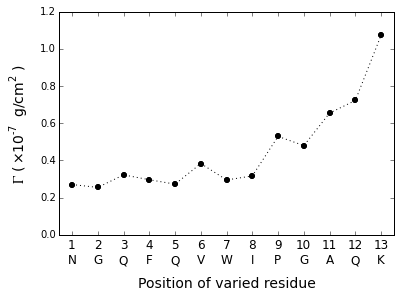

In [80]:
if signal == 'dIm EP Peptide':
    plot_sd(sd)
    
# plot_sd(sd)

check the legend text


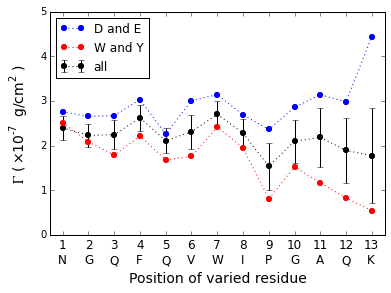

In [81]:
if signal == 'dIm EP Peptide':
    print 'check the legend text'
    plot_avg(avg, sd, avg_high, avg_low)
    
# plot_avg(avg, sd, avg_high, avg_low)

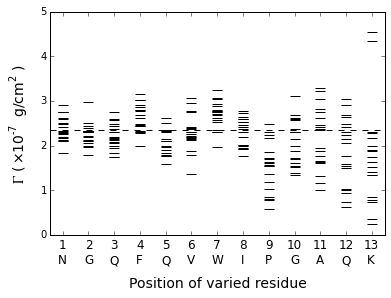

In [82]:
if signal == 'dIm EP Peptide':
#    plot_agg(agg, agg_high, agg_low)
    plot_agg(agg)
elif signal == 'dIm EP Streptavidin':
    plot_agg(agg)

In [83]:
# df = subset(base, 7)
# df

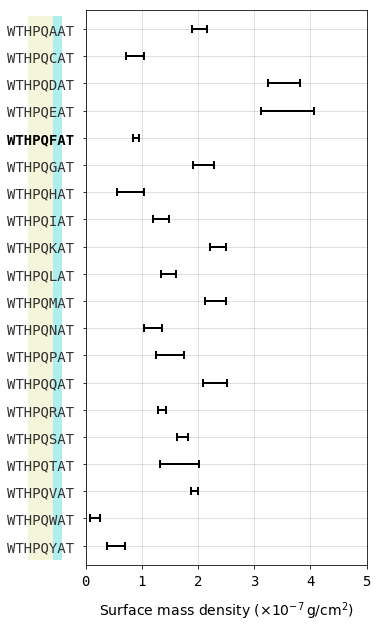

In [11]:
n = 6
plot_series(subset(base, n), n, signal, 'a')

In [85]:
# for i in range(1, length + 1):
#     data = subset(base, i)
#     maxG = (data['Streptavidin Mean NN']).max() * dIm_to_gamma * 10**7
#     minG = (data['Streptavidin Mean NN']).min() * dIm_to_gamma * 10**7
#     print 'residue position =', n
#     print 'max Gamma', maxG
#     print 'min Gamma', minG
#     print 'ratio =', maxG / minG, '\n'